In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [21]:
#conda install -c conda-forge ipywidgets
#conda install nodejs
#jupyter labextension install @jupyter-widgets/jupyterlab-manager

import os, sys, shutil, glob, re, subprocess, fileinput
import pandas as pd
import numpy as np
from copy import copy
from collections import OrderedDict
from math import floor
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display
import plotnine as p9
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import MDAnalysis

%matplotlib notebook

# Set input files, options, and atoms for colvars

In [84]:
pdbFile = "./setup/decarboxylase.0.pdb"
psfFile = "./setup/decarboxylase.0.psf"

#dcdFile = "./SMD_Data/min_smd.dcd"
#xstFile = "./SMD_Data/min_smd.xst"
dcdFile = "./SMD_Data/smd.dcd"
xstFile = "./SMD_Data/smd.xst"

## Calculation options

basePath = "./String_eABF"
setupPath = basePath + "/setup/"
outputPath = basePath + "/output/"

parallelExec = False
sequentialExec = True

stringNumIter = 20
stringNumWalkers = 5
atomDistList = []

eABFnumSteps = 10000

### Decarboxylase

#  WARNING:  0-based index for VMD!!!
#  WARNING:  1-based index for colvars!!!

# This list should be built with VMD's 0-based index
atomDistList.append( (3311,3312,"OMP C6 <-> OMP C7") )
atomDistList.append( (3311,1020,"OMP C6 <-> Lys61 HZ1") )
#atomDistList.append( (1019,1020,"Lys61 NZ <-> Lys61 HZ1") )
atomDistList.append( (3314,980,"OMP OA <-> Asp59 OD2") )
atomDistList.append( (3313,979,"OMP OB <-> Asp59 OD1") )

atomDistList

[(3311, 3312, 'OMP C6 <-> OMP C7'),
 (3311, 1020, 'OMP C6 <-> Lys61 HZ1'),
 (3314, 980, 'OMP OA <-> Asp59 OD2'),
 (3313, 979, 'OMP OB <-> Asp59 OD1')]

# Set paths for tools used along the tutorial

In [85]:

tempDir = "./tmp"

qmBinPath = "/home/melomcr/Projects_melomcr/Programs/MOPAC_GPU/MOPAC2016.exe"

if sys.platform == 'linux':
    catdcdPath = "catdcd"
    vmdPath = "vmd"
    namdPath = "/Projects/melomcr/NAMD_Gerrit/namd/Linux-x86_64-g++.mpi/namd2"
    
elif sys.platform == 'darwin':
    catdcdPath = "/Applications/VMD\ 1.9.4.app/Contents/vmd/plugins/MACOSXX86/bin/catdcd5.2/catdcd"
    vmdPath = "/Applications/VMD\ 1.9.4.app/Contents/Resources/VMD.app/Contents/MacOS/vmd"

# Calculate colvar values during SMD trajectory.

*We will now use the MDAnalysis module to calculate the values of collective variables along the SMD trajectory. As we direct atoms' movements to induce the chemical reaction, the relevant distances between atom pairs will oscilate and vibrate during the MD simulation.*

### Working with large volumes of data: Pandas


### Re-arranging data for faster and easier statistics calculation and plotting:  Melt/Cast



In [86]:
%%time

if not os.path.exists(tempDir):
    os.mkdir(tempDir)

numColvars = len(atomDistList)
keyNameDic = { "dist"+str(indx) : str(atomDistList[indx][2]) for indx in range(numColvars) }
    
# Open the PSF and SMD DCD files
u = MDAnalysis.Universe(psfFile,dcdFile)

# Creates atom selection objects
selPairList = []
for cvSel in atomDistList:
    selPairList.append((u.atoms[cvSel[0]], u.atoms[cvSel[1]] ) )

# Initialize the data-frame with standard column names
cvSMD = pd.DataFrame(columns=[ "dist"+str(i) for i in range(numColvars) ])

def calcCV(ts):
    
    return [ np.linalg.norm( selPairList[cvIndx][0].position - selPairList[cvIndx][1].position ) \
         for cvIndx in range(numColvars) ]


# Process trajectory
cvSMD = pd.DataFrame([calcCV(ts) for ts in u.trajectory])
cvSMD.rename(index=str, columns={ cvIndx:"dist" + str(cvIndx) for cvIndx in range(numColvars) }, inplace=True)
cvSMD.reset_index(drop=True, inplace=True)

numFrames = len(cvSMD)

cvSMDMelt = pd.melt(cvSMD, var_name="colvar", value_name="Distance")

CPU times: user 1.05 s, sys: 245 ms, total: 1.29 s
Wall time: 1.3 s


## Select initial string images

*In order to initiate the string optimization, we must choose frames from the trajectory that represent significant steps during the reaction, keeping a good resolution of the chemical process being studied. This process can be tedious and repetitive if done manually, particularly for transformations that can be abrupt and rare. The graphics and tools in the cell below will help analyze colvar values along the trajectory, and select the best frames to initialize the string optimization.*

VBox(children=(HBox(children=(BoundedIntText(value=10, description='Initial Images:', max=40, min=3, style=DescriptionStyle(description_width='initial')), IntSlider(value=3, max=40, min=3, readout=False), BoundedIntText(value=0, description='Offset:', max=3153, style=DescriptionStyle(description_width='initial')), Button(button_style='danger', description='Reset Selection', icon='eraser', style=ButtonStyle(), tooltip='Resets all selections and allows a new set of evenly spaced images to be created.'))), HBox(children=(ToggleButton(value=False, button_style='info', description='Add Intermediates', icon='square', tooltip='Adds intermediate images in regions of high variability. This will lock the number of evenly spaced images selected above.'), BoundedFloatText(value=0.3, description='Maximum delta:', disabled=True, style=DescriptionStyle(description_width='initial')), ToggleButton(value=True, button_style='info', description='Add last frame', disabled=True, icon='check-square', style=DescriptionStyle(description_width='initial'), tooltip='Add an image at the last step of the simulation.'), Button(button_style='warning', description='calculate', disabled=True, icon='retweet', style=ButtonStyle(), tooltip='(Re)Calculate intermediate images. This may take some time.'))), HBox(children=(Text(value='0', description='Total Images:', disabled=True), Button(icon='plus', style=ButtonStyle(), tooltip='Add Image'), Button(icon='minus', style=ButtonStyle(), tooltip='Remove Image'), Dropdown(description='Image:', options={'Zero': 0}, value=0), BoundedIntText(value=0, description='Frame:', max=3153, style=DescriptionStyle(description_width='initial'))))))

<IPython.core.display.Javascript object>


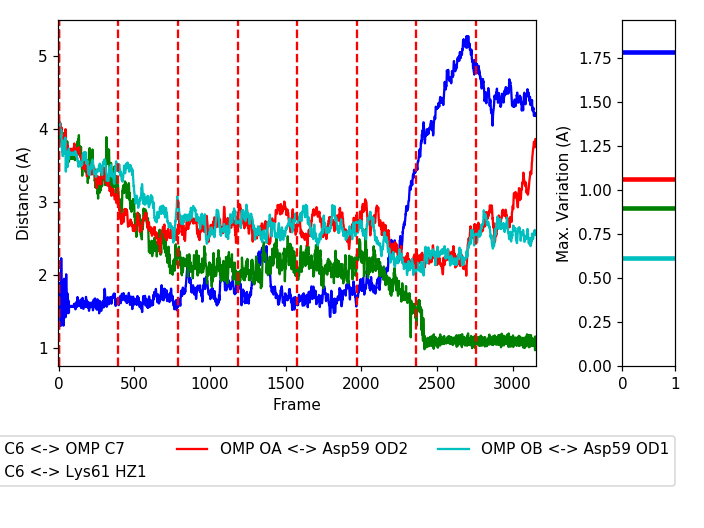

In [87]:
%matplotlib notebook

class imageDat:
    ''' Holds data on selected images for String Optimization'''
    
    frame = 0
    ftype = 0
    selected = False
    
    def __init__(self, frame=0, ftype=0, selected=False):
        self.frame = frame
        self.ftype = ftype
        self.selected = selected

allImages = []
numImgs = len(allImages)   # Will initialize as zero
defaultNumImgs = 10

# Sets widgets to select number of images
imagesText = widgets.BoundedIntText(
    value=defaultNumImgs, step=1, min=3, max=40, 
    description="Initial Images:",
    style={'description_width': 'initial'}
)
imagesSlider = widgets.IntSlider(
    value=numImgs, step=1, readout=False, min=3, max=40
)
offsetText = widgets.BoundedIntText(
    value=numImgs, step=1, min=0, max=numFrames,
    description="Offset:",
    style={'description_width': 'initial'}
)
resetSelB = widgets.Button(
    value=False,
    description='Reset Selection',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Resets all selections and allows a new set of evenly spaced images to be created.',
    icon='eraser'
)

mylink = widgets.jslink((imagesText, 'value'), (imagesSlider, 'value'))

hboxImgs = widgets.HBox([imagesText,imagesSlider,offsetText,resetSelB])

# Sets widgets to automatically create images in high variability regions.
activateInterTB = widgets.ToggleButton(
    value=False,
    description='Add Intermediates',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Adds intermediate images in regions of high variability. \
This will lock the number of evenly spaced images selected above.',
    icon='square' # "check-square" vs "square"
)
defaultMaxDelta = 0.3
maxDeltaFT = widgets.BoundedFloatText(
    value=defaultMaxDelta, min=0, 
    description="Maximum delta:",
    style={'description_width': 'initial'},
    disabled=True
)
addLastTB = widgets.ToggleButton(
    value=True,
    description='Add last frame',
    style={'description_width': 'initial'},
    disabled=True,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Add an image at the last step of the simulation.',
    icon='check-square' # "check-square" vs "square"
)
calcInterB = widgets.Button(
    value=False,
    description='calculate',
    disabled=True,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='(Re)Calculate intermediate images. This may take some time.',
    icon='retweet'
)

hboxInter = widgets.HBox([activateInterTB, maxDeltaFT, addLastTB, calcInterB])

# Sets widgets to indicate total number of images
totalImagesText = widgets.Text(
    value='0',
    description='Total Images:',
    disabled=True
)

imgSelect = widgets.Dropdown(
    options={'Zero': 0},
    value=0,
    description='Image:',
)

imgChgFrameText = widgets.BoundedIntText(
    value=0, min=0, max=numFrames,
    description="Frame:",
    style={'description_width': 'initial'}
)

addImg = widgets.Button(
    description='',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Add Image',
    icon='plus'
)

rmImg = widgets.Button(
    description='',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Remove Image',
    icon='minus'
)

hboxFT = widgets.HBox([totalImagesText, addImg, rmImg, imgSelect, imgChgFrameText])

def resetImages(imgCount = defaultNumImgs):
    '''Creates main images. Erases all prior image data.'''
    global allImages, numImgs
    
    if imgCount > 40:
        raise Exception('Too many images!')
    
    offset = offsetText.value
    
    # Initializes number of frames between images as one tenth of total frames, rounding down, and 
    # making sure we have at least 1 (one) frame between images
    imgStride = max(floor( (numFrames-offset)/imgCount ),1)
    allImages = [ imageDat(frame=(x*imgStride) + offset) for x in range(imgCount)]
    numImgs = len(allImages)
    
resetImages()

def toggle_addLast(*args):
    if addLastTB.value:
        addLastTB.icon = "check-square"
    else:
        addLastTB.icon = "square"

addLastTB.observe(toggle_addLast,"value")


# Displays all widgets
ui = widgets.VBox([hboxImgs, hboxInter, hboxFT])
display(ui)

# Build basic plot
xrange = np.arange(0, numFrames, 1)

fig = plt.figure()
gs = gridspec.GridSpec(2, 2, width_ratios=[9, 1], height_ratios=[7,1])
ax = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
lax = plt.subplot(gs[1,:])

ax.set(xlabel='Frame', ylabel='Distance (A)')
ax1.set(xlabel='', ylabel='Max. Variation (A)')
ax1.set_ylim([0,1.5])

plt.show()

colors = ['b','g','r','c','m']
styles = ['-','-.','--',':']
styleTupls = []

def getStyleTupl(i):
    cIndx = i%len(colors)
    sIndx = int(i/len(colors))
    return (colors[cIndx],styles[sIndx])

deltaLines = []
# Populate with selected colvar values
for key, grp in cvSMDMelt.groupby(['colvar']):
    colStyl = getStyleTupl(len(styleTupls))
    styleTupls.append( colStyl )
    ax = grp.plot(ax=ax, kind='line', x=xrange, y='Distance', label=keyNameDic[key], 
                  color=colStyl[0], style=colStyl[1])
    
    # Initializes points used for CV deltas
    deltaLines.append(ax1.axhline(y=0, linewidth=3, 
                                  label=key, color=colStyl[0], linestyle=colStyl[1]) )
    
    plt.draw()

ax.set_xlim([-2,numFrames+2])

h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, ncol=3)
lax.axis("off")

ax.legend().set_visible(False)
ax1.legend().set_visible(False)

linesList = []

def setMainImages(*args):
    resetImages(imgCount= imagesText.value)
    update_plot()

imagesText.observe(setMainImages, 'value')

def update_TotImgs(*args):
    global allImages
    totalImagesText.value = str(len(allImages))

imagesText.observe(update_TotImgs, 'value')

# Determines the maximum variation in ColVar values between sequential images.
def find_max_delta(allImages):
    
    numImgs = len(allImages)
    
    maxDeltaCV = [0]*len(cvSMD.columns)
    maxDeltaFrames = [ [0,0] for i in range(len(cvSMD.columns)) ]
    
    for indx in range(1,numImgs):
        
        frameFin = allImages[indx].frame
        frameIni = allImages[indx -1].frame
        
        for colIndx in range(len(cvSMD.columns)):
            
            delta = abs( cvSMD.iloc[frameFin,colIndx] - cvSMD.iloc[frameIni,colIndx] )
            
            if maxDeltaCV[colIndx] < delta:
                maxDeltaCV[colIndx] = delta
                maxDeltaFrames[colIndx][0] = frameIni
                maxDeltaFrames[colIndx][1] = frameFin
    
    return(maxDeltaCV,maxDeltaFrames)

def toggle_reset(*args):
    
    # Resets interface
    imagesText.disabled = False
    imagesSlider.disabled = False
    offsetText.disabled = False
    
    activateInterTB.value = False
    toggle_intermediate()
    
    # Resets user input data
    maxDeltaFT.value = defaultMaxDelta
    imagesText.value = defaultNumImgs
    
    # Resets image selection
    resetImages()
    
    # updates plot
    update_plot()
    update_TotImgs()
    
resetSelB.on_click(toggle_reset)

def update_plot():
    
    global allImages,numImgs, maxDeltaFrames
    
    # Initialize Images on the plot
    
    lineIndx = 0
    for imageObj in allImages:
        
        # We determine the line color
        color = ''
        # Red for main images (equally spaced)
        if imageObj.ftype == 0:
            color = 'r'
        elif imageObj.ftype == 1:
            color = 'g'
        # Blue for interspaced and last frame (if requested)
        else:
            color = 'b'
        
        if imageObj.selected:
            color = 'gold'
        
        # If we can use previously created vertical line objects for the plot, update their values
        if lineIndx < len(linesList):
            linesList[lineIndx].set_xdata(imageObj.frame)
            linesList[lineIndx].set_color(color)
        else:
            # If not, create new vertical lines in the plot.
            linesList.append( ax.axvline(x=imageObj.frame, color=color, linestyle="--") )
        lineIndx += 1
    
    while lineIndx < len(linesList):
        linesList[lineIndx].set_xdata(allImages[0].frame)
        linesList[lineIndx].set_color("r")
        lineIndx += 1
    
    maxDeltaCV,maxDeltaFrames = find_max_delta(allImages)
    
    index = 0
    for delta in maxDeltaCV:
        deltaLines[index].set_ydata(delta)
        index += 1
    
    ax1.set_ylim([0,max(maxDeltaCV)*1.1])
    
    fig.canvas.draw()

def calcIntermediates():
    
    global allImages,numImgs
    
    # Gets current Maximum Delta
    maxD = float(maxDeltaFT.value)
    
    # Clears all intermediate images, and added last frame.
    allImages = [img for img in allImages if img.ftype in [0,1]]
    numImgs = len(allImages)
    
    # Add last frame as main image, if requested.
    if addLastTB.value:
        if (allImages[-1].frame != (len(cvSMD)-1)):
            allImages.append( imageDat(frame=len(cvSMD)-1, ftype=5) )
            numImgs = len(allImages)
    
    interImgs = []
    
    # Loops over all Equally Spaced "gaps"
    for indx in range(1,numImgs):
        
        frameFin = allImages[indx].frame
        frameIni = allImages[indx -1].frame
        
        tmpIni = frameIni
        tmpFin = frameFin
        
        cvCheck = np.asarray([False]*numColvars)
        
        while tmpIni != frameFin:
            
            # Looks for the first cv index that needs to be checked.
            if len(np.where(cvCheck == 0)[0]):
                colIndx = np.where(cvCheck == 0)[0][0]
            else:
                # If all indices are true, update the tmpIni and reset the count.
                cvCheck = np.asarray([False]*numColvars)
                # In this order!
                tmpIni = tmpFin
                tmpFin = frameFin
                
                # If we found a new image, add it to the list
                if tmpIni > frameIni and tmpIni != frameFin:
                    interImgs.append(tmpIni)

            # If the difference in this colvar is less than the maximum,
            # skip to the next.
            tmpdelta = abs( cvSMD.iloc[tmpFin,colIndx] - cvSMD.iloc[tmpIni,colIndx] )
            if tmpdelta <= maxD:
                cvCheck[colIndx] = True
                continue
            
            # Ugly trick to get the first frame, between two images, with a ColVar
            # variation larger than maxD. 
            # R + data.table would do this much more "cleanly", but I'll stop complaining...
            baseVal = cvSMD.iloc[tmpIni,colIndx]
            queryStr = "abs(" + str(baseVal) + "-" + str(cvSMD.columns[colIndx]) + ") >= " + str(maxD)
            indxV = cvSMD.iloc[tmpIni:tmpFin,:].query(queryStr)
            
            # In case there is at least one frame where this ColVar has a variation greater than maxD,
            # we store the frame.
            if len(indxV) > 0 :
                # We also make sure that the image is *after* the initial frame.
                tmpNewFrame = (indxV.index[0] - 1)
                if tmpNewFrame > tmpIni:
                    tmpFin = tmpNewFrame
                    # If we found a new intermeiate image, uncheck all colvars and check the current one.
                    cvCheck = np.asarray([False]*numColvars)
                    cvCheck[colIndx] = True
                    
            else:
                cvCheck[colIndx] = True
    
    # Add new images to the global list
    for frame in interImgs:
        allImages.append( imageDat(frame=frame, ftype=2) )
    
    # Sort all images
    allImages = sorted(allImages, key=lambda x: x.frame)
    numImgs = len(allImages)

def toggle_calcInter(*args):
    calcIntermediates()
    update_plot()

calcInterB.on_click(toggle_calcInter)
calcInterB.on_click(update_TotImgs)

def update_offset(*args):
    '''Call function to reset all initial images using the new value for offset.'''
    resetImages(imagesText.value)
    update_plot()

offsetText.observe(update_offset,'value')

# Connects inputs
def toggle_intermediate(*args):
    # Activate user input
    
    # Change icon and Lock Image Selection.
    if activateInterTB.value:
        activateInterTB.icon = "check-square"
        maxDeltaFT.disabled = False
        addLastTB.disabled = False
        calcInterB.disabled = False
        
        imagesText.disabled = True
        imagesSlider.disabled = True
        offsetText.disabled = True
    else:
        activateInterTB.icon = "square"
        maxDeltaFT.disabled = True
        addLastTB.disabled = True
        calcInterB.disabled = True
        
activateInterTB.observe(toggle_intermediate, "value")

def update_imgSel(*args):
    
    global allImages
    
    optDict = { str(indx) + " (" + str(img.frame) + ")":indx for indx,img in enumerate(allImages) }
    
    imgSelect.options = OrderedDict(sorted(optDict.items(), key=lambda t: t[1]))

totalImagesText.observe(update_imgSel,'value')

def selection_update(*args):
    
    global allImages
    
    imgChgFrameText.value = allImages[ imgSelect.value ].frame
    
    for img in allImages:
        img.selected = False
    allImages[ imgSelect.value ].selected = True
    
    update_plot()

imgSelect.observe(selection_update,'value')

def update_image(*args):
    
    global allImages
    
    newVal = imgChgFrameText.value
    
    if newVal >= numFrames -1 or newVal < 0:
        return
    
    switchOccurred = False
    
    if newVal < allImages[ imgSelect.value ].frame:
        # If there is a next image, we make sure we don't change the order of images
        if imgSelect.value - 1 >= 0:
            if newVal < allImages[ imgSelect.value - 1 ].frame:
                switchOccurred = True
        
    if newVal > allImages[ imgSelect.value ].frame:
        # If there is a next image, we make sure we don't change the order of images
        if imgSelect.value + 1 <= numImgs - 1:
            if newVal > allImages[ imgSelect.value + 1 ].frame:
                switchOccurred = True
    
    allImages[ imgSelect.value ].frame = newVal
    if switchOccurred:
        allImages = sorted(allImages, key=lambda x: x.frame)
        update_imgSel()
        
        for indx,img in enumerate(allImages):
            if img.frame == newVal:
                imgSelect.value = indx
        
        selection_update()
        
    update_plot()

imgChgFrameText.observe(update_image, 'value')

def add_img(*args):
    
    global allImages,numImgs
    
    selectedImg = imgSelect.value
    
    iniFrame = allImages[ selectedImg ].frame
    if selectedImg < numImgs-1:
        finFrame = allImages[ selectedImg + 1 ].frame
    else:
        if iniFrame < numFrames-1:
            finFrame = numFrames-1
        else:
            return
    
    newframe = int(np.floor((iniFrame + finFrame)/2))
    
    if (newframe != iniFrame):
        allImages.append( imageDat(frame=newframe, ftype=1) )
        
        # Sort all images
        allImages = sorted(allImages, key=lambda x: x.frame)
        numImgs = len(allImages)
        
        update_plot()
        update_TotImgs()
        imgSelect.value = selectedImg + 1

addImg.on_click(add_img)

def rm_img(*args):
    
    global allImages,numImgs
    
    selectedImg = imgSelect.value
    
    # If tehre are only three, don't do anyhting or we would get less images than the minimum.
    if numImgs == 3:
        return
    
    # After deleting the image, select the one before it.
    newSel = 0
    if selectedImg == 0:
        newSel = 1
    else:
        newSel = selectedImg -1
    
    # deletes the image
    del allImages[selectedImg]
    
    numImgs = len(allImages)
    
    # Updates widget and plot
    update_plot()
    update_TotImgs()
    imgSelect.value = newSel
    
    
rmImg.on_click(rm_img)
    
update_plot()

update_TotImgs()

plt.tight_layout()

In [ ]:
###  2 TABS = all frames (Value vs Frame) + MaxVar | All Images (Value vs Image Index) + Min/Avr/Max Var
### Color backgroud by Max Var ?

In [88]:
print("Frame Offset:",offsetText.value,"; Number of main images:", imagesText.value, ";  Max delta:", maxDeltaFT.value)

Frame Offset: 0 ; Number of main images: 8 ;  Max delta: 0.3


In [89]:
frames = [f.frame for f in allImages]

print("We selected",numImgs,"images:",frames)

We selected 8 images: [0, 394, 788, 1182, 1576, 1970, 2364, 2758]


# Creates COOR and XSC files to initiate String calculation

In [ ]:
# Erases setup files if they exist. We start from scratch to avoid future errors.
if os.path.exists(basePath):
    shutil.rmtree(basePath)
os.makedirs(setupPath)
os.makedirs(outputPath)

# Creates output directories for each image
if parallelExec:
    numOutFolders = numImgs*stringNumWalkers
elif sequentialExec:
    numOutFolders = numImgs

for i in range(numOutFolders):
    os.makedirs(outputPath + "/" + str(i))

print("Total selected frames:",len(frames))

stringFileList = []
stringIndex = 0
for frame in frames:
    
    # Creates a list of DCD files that will be used to write configuration files for the String.
    stringFileList.append("image_"+str(stringIndex)+".coor")
    
    # Writes selected frames to DCD files for String input
    print("Writing frame " + str(frame) + " to file " + stringFileList[-1])
    command = catdcdPath + " -o " + setupPath + stringFileList[-1] + " -otype namdbin -stype psf -s " + psfFile + \
        " -first " + str(frame+1) + " -last " + str(frame+1) + " -dcd " + dcdFile
    process = subprocess.Popen(command, shell=True)
    process.wait()

    # Exact frames from the XST file for String input
    sedFile = setupPath + "image_" + str(stringIndex) + ".xsc"
    tmpFile = open(sedFile,"w")
    tmpFile.write("""# NAMD extended system trajectory file
#$LABELS step a_x a_y a_z b_x b_y b_z c_x c_y c_z o_x o_y o_z
""")
    tmpFile.close()
    sedLine = "cat " + xstFile + " | grep -v ^# | sed -n " + str(frame + 1) + "p >> " + sedFile 
    process = subprocess.Popen(sedLine, shell=True)
    process.wait()
    
    stringIndex += 1


# Creates Configuration files to initiate String calculation

### We create configuration files for both String and eABF because we already have all the necessary data and parameters for both, but the eABF calculation will still need structural data that we will gather from the results of the String optimization.

In [ ]:

##### Writes all configuration files for the String Method optimization.

# First we create the common block of text for defining Colective Variables, and use python's "format" capability
# to insert data for each ColVar, in each Image.
# OBS: In Python's "format" module, every keyword enclosed in curly brackets will be substituted by a value 
#  provided in a dictionary. If the final string needs actual curly brackets, they can be excaped by using 
#  two consecutive brackets.

colvarBlock = """
# {CVlabel}
colvar {{
    name swarms_atmDist{CVcolIndx}
    distance {{
        group1 {{
            atomNumbers {atmIndx1}
        }}
        group2 {{
            atomNumbers {atmIndx2}
        }}
    }}
}}

harmonic {{
    name bias_swarms_atmDist{CVcolIndx}
    colvars swarms_atmDist{CVcolIndx}
    centers {CVcenter}
    forceConstant 0.0
}}

"""

# Now we write each file (one per image), containing their particular initial values for the ColVars.
for imgIndx in range(len(frames)):
    
    # We create one file per image in the string.
    stringFile = open(setupPath + "colvars_" + str(imgIndx) + ".conf",'w')
    
    # Common colvar communication freqeuncy
    stringFile.write("\ncolvarsTrajFrequency 5\n\n")
    
    for colIndx in range(len(cvSMD.columns)):
        colName = cvSMD.columns[colIndx]
        
        #print("Frame " + str(imgIndx) + "; Dim " + colName + "; indxPair: " + str(atomDistList[colIndx][0]) \
        #      + " <-> " + str(atomDistList[colIndx][1]) + "; label: " + atomDistList[colIndx][2])
        
        # Now we aggregate the information for each colvar and each image.
        currInfo = {}
        currInfo['CVlabel'] = atomDistList[colIndx][2]
        currInfo['CVcolIndx'] = str(colIndx)
        # Convert VMD 0-base index to ColVar 1-base index.  
        currInfo['atmIndx1'] = atomDistList[colIndx][0] + 1
        currInfo['atmIndx2'] = atomDistList[colIndx][1] + 1
        currInfo['CVcenter'] = cvSMD.iloc[frames[imgIndx],colIndx]
        
        # Finally, we substitute the values in the common string block and write it to the file.
        stringFile.write( colvarBlock.format(**currInfo) )
    
    
    stringFile.close()
########



In [ ]:

##### Writes the configuration file for the eABF Free Energy calculation.

# Path Collective Variables use the RMSD of relevant atoms to describe the reaction coordinate. For that, we need 
# the atom numbers of all atoms involved in colvars we set at the begining of the notebook.
# We can use python's flexibility to create a unique set of atom indices in one line.
# Warning: Computational tricks ahead! Using "list comprehension", we can create a list by calling each colvar
#    (or cv) in atomDistList, select only the frist two items (the 0-based atom indices) and create
#    a set for with them shifted to 1-based index. List comprehensions, automatically combine all pairs in a list 
#    (by doing this operation within brackets), and the resulting list of sets is unpacked by placing an '*' in 
#    fornt of it. The unpacked list of sets is used by the 'set.union' operation to create a union of all sets. 

atmsUnion = set.union(*[ set([cv[0]+1,cv[1]+1]) for cv in atomDistList ])

# An equivalent operation that would be easier to read can be found below, but we can take the oportunity to 
# get used to pyhton's toolset, writing 1 line of code instead of 4.
## atmsUnion = set()
## for cv in atomDistList:
##     for atm in [cv[0]+1,cv[1]+1]:
##         atmsUnion.add(atm)


# Sets common text block that will be used to set all points along the optimized string. 
# This defines the path that eABF will use to calculate the free energy.
# The atomNumbers are common to all points that define the path, so we add them to the common text block now.
allAtmsList = [atom for atom in atmsUnion]
# We need to sort the atom indices! ColVars modules needs ordered indices for RMSD calculation.
allAtmsList.sort()
# Now we create a list of strings, so we can use the "join" method to 
# join all atom numbers with spaces in between.
allAtmsStr = ' '.join([str(atom) for atom in allAtmsList])
pathNodeStr = """
rmsd {{
 atoms {{
   atomNumbers {{ """ + allAtmsStr + """ }}
 }}
 refpositionsfile ./string/string_{imgIndx}.pdb
}}
"""
#refpositionsfile "${{imageRoot}}/string_{imgIndx}.pdb"

# Only one configuration file is needed for eABF.
pathCVFile = open(setupPath + "pathCV.conf",'w')

# We use the final images form a string optimization. Files have to be converted from coor to pdb.
#pathCVFile.write("\nset imageRoot \"./string/\"\n\n")

# Common colvar communication freqeuncy
pathCVFile.write("colvarsTrajFrequency 5\n\n")

# Now we set the two collective variables needed for eABF, the path collective variables.

# Colvar 's' defines the position of the simulations along the path
begCVs = """
colvar {
   name                  s

   width                 0.05
   lowerboundary         0.0
   upperboundary         1.0
   lowerwallconstant     10.0
   upperwallconstant     10.0

   scriptedFunction      pathCVs
   extendedLagrangian    on
   extendedFluctuation   0.01

"""
pathCVFile.write(begCVs)

# Writes all the definitions of points along the path.
for imgIndx in range(len(frames)):
    pathCVFile.write( pathNodeStr.format(**{'imgIndx': imgIndx}) )

# Closes the first colvar block
pathCVFile.write("}\n\n")

# Colvar 'z' defines the distance of the simulations 'perpendicular' the path
begCVz = """
colvar {
   name                  z

   width                 0.05
   lowerboundary        -0.5
   upperboundary         1.5

   scriptedFunction      pathCVz
   extendedLagrangian    on
   extendedFluctuation   0.01
"""
pathCVFile.write(begCVz)

# Writes all the definitions of points along the path.
for imgIndx in range(len(frames)):
    pathCVFile.write( pathNodeStr.format(**{'imgIndx': imgIndx}) )

# Closes the first colvar block
pathCVFile.write("}\n\n")

# We sill configure the eABF sampling to run only along the 's' variable. This will not give us
# the best possible estimate, but will be computationally cheaper since we need only sample one dimension.
# The eABF algorithm will apply forces on the virtual particle in a region only after acquiring 100 samples
# in that region. We are using multiple walkers initialized along the string to speed up the sampling process.
# The 'z' colective variable is only used to keep the eABF virtual particle from wandering away from the main 
# path.
configPathCV = """
abf {
    #colvars s z
    colvars s
    fullSamples 100

    # Multiple-replica ABF
    shared yes
    sharedFreq 5
    
    # CZAR is the default
    #CZARestimator yes
    #writeCZARwindowFile yes
    
}

harmonic {
   colvars               z
   centers               0.0
   forceConstant         0.5
}

"""
pathCVFile.write(configPathCV)

pathCVFile.close()

# Populate the String/eABF work directory with the necessary files.

### We now copy essential files from the decarboxylase system (such as PDB, PSF, topology) and configuration files from the 'templates' directory.
### Some of files need specific data that is only knwon after we setup our system, decide on parameters, chose images, etc.

In [ ]:

# Get structure data and NAMD parameters
shutil.copy(pdbFile, basePath)
shutil.copy(psfFile, basePath)

shutil.copytree('./setup/toppar', basePath + '/toppar')

# Get TCL code and parameters for String and eABF calculation
for filename in glob.glob('./templates/*'):
    shutil.copy(filename, basePath)

# Create directory in RAM for faster QM calculation and I/O.
# This path is used in the "namd.conf" file.

if sys.platform == 'linux':
    os.makedirs("/dev/shm/NAMD_SM_qmmm", exist_ok=True)

with fileinput.FileInput(basePath + "/namd.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("QMBINPATH", qmBinPath), end='')

with fileinput.FileInput(basePath + "/string_param.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("STRINGITERATIONS", str(stringNumIter)), end='')

with fileinput.FileInput(basePath + "/string_param.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("NUMWALKERS", str(stringNumWalkers)), end='')

if parallelExec:
    eABFWalkersPerImg = stringNumWalkers
elif sequentialExec:
    eABFWalkersPerImg = 1
    
with fileinput.FileInput(basePath + "/eABF.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("EABFSTEPS", str(eABFnumSteps)), end='')

with fileinput.FileInput(basePath + "/eABF.conf", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("EABFWPERIMG", str(eABFWalkersPerImg)), end='')

## To visualize the file in the notebook, use the magic:

### %load "file-name"
## To save modifications made to file, add the following magic to the top of the cell (DO NOT use quotes around the file name!):
### %%writefile file-name

#
# Run the calculation!
#


### For fully parallel calculations in clusters (using multiple nodes), where all walkers from all swarms of all images walk at the same time, use the file "string_parallel.tcl".
### For single-node calculations, where wlakers of a same image walk sequentially, but walkers of different images walk simultaneously, use "string_sequential.tcl". Warning: The node needs to have at least as many processor cores as there are images in the string.

### An example of a command that can be ran in the terminal window would be:

### mpirun -n 17 /Projects/melomcr/NAMD_Gerrit/namd/Linux-x86_64-g++.mpi/namd2 +replicas 17 string_sequential.tcl +stdout output/%1d/job00.%1d.log

In [77]:
%%bash -s "$numImgs"  "$namdPath"

echo "Calculating $1 images..."

cd String_eABF/

#ls

echo "mpirun -n $1 $2 +replicas $1 string_sequential.tcl +stdout output/%1d/job00.%1d.log"
#mpirun -n $1 $2 +replicas $1 string_sequential.tcl +stdout output/%1d/job00.%1d.log

cd ..

Calculating 10 images.
mpirun -n 10 /Projects/melomcr/NAMD_Gerrit/namd/Linux-x86_64-g++.mpi/namd2 +replicas 10 string_sequential.tcl +stdout output/%1d/job00.%1d.log


## We backup the results just in case...

In [ ]:
backUP = False
if backUP:
    resultsStringDirBase = "Results_String"

    backupList = [dir for dir in glob.glob(resultsStringDirBase + "_*")]

    newBackDir = resultsStringDirBase + "_" + str(len(backupList)+1)
    print("Creating backup in",newBackDir,"... this may take a minute.")
    shutil.copytree(outputPath, newBackDir)


# Read results from String Optimization

In [90]:
if parallelExec:
    numOutFolders = numImgs*stringNumWalkers
elif sequentialExec:
    numOutFolders = numImgs

print("Examining output in",numOutFolders,"folders...")

Examining output in 8 folders...


In [221]:

# We are looking for the following pattern inside the log file:
# Updating bias_swarms_atmDist1
# colvars:   # centers = { 4.14177 }
    
# First, we compile a Regular Expression to look for the correct format.
# Regular expression are a powerful tool to match patterns in text files that have complex formats.
regexVal = re.compile("^colvars:   # centers = { ([0-9\.]*) }$")
regexName = re.compile("^Updating bias_swarms_atmDist([0-9]*)$")

# Create a Pandas dataframe with systematic column names (so it's easy to access in the future).
cvString = pd.DataFrame(columns=[ "dist"+str(i) for i in range(numColvars) ] + ["Image","Iter"])

# Initialize with colvar values taken from SMD simulation that initiated the String optimization.
for i in range(numImgs):
    cvString.loc[i] = list(cvSMD.iloc[frames[i],:]) + [i, 0]

# Loop over all images
for image in range(numImgs):
    
    if parallelExec:
        foldIndx = image*stringNumWalkers
    else:
        foldIndx = image
    
    logFiles = []
    folderStr = outputPath + str(foldIndx)
    for logFN in glob.iglob(folderStr + "/job*.log"):
        logFiles.append(logFN)
    
    ## Assuming there is only one log file per image, for now.
    fileName = logFiles[0]
    
    # Set temporary variables
    colvarName = ""
    numIterations = 1
    tmpDF = pd.DataFrame()
    
    with open(fileName,'r') as fileHandle:
        print("Processing file",fileName)
        
        for line in fileHandle:
            matchVal = regexVal.match(line.strip())
            matchName = regexName.match(line.strip())
            
            # First we check if the line provides a name for a colvar (the value will follow in the next line)
            if matchName:
                colvarName = line.strip().split(" ")[1]
                cvIndx = matchName.group(1)
            
            # We only consider matching value strings after we match at least one name string.
            if matchVal and colvarName:
                colvarValue = matchVal.group(1)
                
                tmpDF.loc[0,"dist" + str(cvIndx)] = round(float(colvarValue),4)
                
            # After accumulating values for all colvars, append to data frame.
            if len(tmpDF.columns) == numColvars:
                tmpDF.loc[0,"Image"] = image
                tmpDF.loc[0,"Iter"] = numIterations
                
                cvString = cvString.append(tmpDF)
                
                numIterations += 1
                # Resets temporary data frame
                tmpDF = pd.DataFrame()

cvString.reset_index(drop=True, inplace=True)

Processing file ./String_eABF/output/0/job00.0.log
Processing file ./String_eABF/output/1/job00.1.log
Processing file ./String_eABF/output/2/job00.2.log
Processing file ./String_eABF/output/3/job00.3.log
Processing file ./String_eABF/output/4/job00.4.log
Processing file ./String_eABF/output/5/job00.5.log
Processing file ./String_eABF/output/6/job00.6.log
Processing file ./String_eABF/output/7/job00.7.log


In [285]:
cvString
cvStringMelt = pd.melt(cvString, id_vars=["Image","Iter"], var_name="colvar", value_name="Distance")

cols = [ "dist"+str(i) for i in range(numColvars) ]
colsTrg = [ "dist"+str(i)+"Dev" for i in range(numColvars) ]

def calculate_deviation(group):
    group[colsTrg] = abs(group.loc[:, cols] - group.loc[group.Iter==max(group.Iter), cols].values[0])
    return group

cvStat = cvString.groupby(['Image']).apply(calculate_deviation)

cvStatMelt = pd.melt(cvStat.loc[:,["Image","Iter"] + colsTrg], id_vars=["Image","Iter"], \
                 var_name="colvar", value_name="Deviation")

cvStat = cvStatMelt.loc[:,cvStatMelt.columns != "Image"].groupby(["Iter","colvar"], as_index=False).mean()
cvStat['MaxDev'] = cvStatMelt.loc[:,cvStatMelt.columns != "Image"].groupby(["Iter","colvar"], as_index=False).max()['Deviation']
cvStat

,Iter,colvar,Deviation,MaxDev
0,0.0,dist0Dev,0.430549,1.561547
1,0.0,dist1Dev,0.293475,0.683023
2,0.0,dist2Dev,0.367179,0.614321
3,0.0,dist3Dev,0.195973,0.460011
4,1.0,dist0Dev,0.057225,0.113700
5,1.0,dist1Dev,0.082237,0.191500
6,1.0,dist2Dev,0.088325,0.131500
7,1.0,dist3Dev,0.044763,0.083900
8,2.0,dist0Dev,0.021437,0.057500
9,2.0,dist1Dev,0.049212,0.147500


HBox(children=(Label(value='Statistic:'), RadioButtons(options=('Mean Deviation', 'Maximum Deviation'), value='Mean Deviation')))

<IPython.core.display.Javascript object>


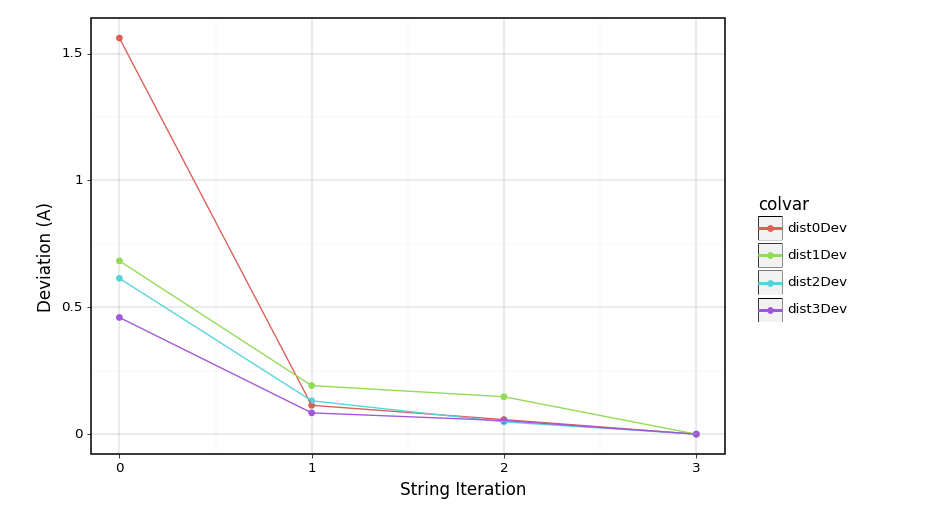

In [290]:
%matplotlib notebook

# Image VS ColvarS, iterated over "time" (string optimization step)

pd.set_option('mode.chained_assignment',None)

radioStat = widgets.RadioButtons(
    options=['Mean Deviation', 'Maximum Deviation'],
    value='Mean Deviation',
    #description='Pizza topping:',
    disabled=False
)

stringCtl = widgets.HBox([widgets.Label(value="Statistic:"), radioStat])

fig = None
axs = None

def plotString(*args):
    
    global fig, axs
    
    if radioStat.value == "Mean Deviation":
        selStr = 'Deviation'
    else:
        selStr = 'MaxDev'
    
    p = p9.ggplot(cvStat, p9.aes(x="Iter", y=selStr, color="colvar")) + \
        p9.geom_point() + p9.geom_path() + p9.theme_linedraw() + \
        p9.labs(x="String Iteration", y="Deviation (A)")
            
    if fig is None:
        fig, plot = p.draw(return_ggplot=True)
        axs = plot.axs
    else:
        for artist in plt.gca().lines +\
                        plt.gca().collections +\
                        plt.gca().artists + plt.gca().patches + plt.gca().texts:
            artist.remove()
        p._draw_using_figure(fig, axs)
    
radioStat.observe(plotString, 'value')

display(stringCtl)

radioStat.value = 'Maximum Deviation'
plt.tight_layout()

HBox(children=(Label(value='Iteration:'), Play(value=1, description='Iterate over the string optimization', interval=1500, max=3), IntSlider(value=1, max=3)))

<IPython.core.display.Javascript object>


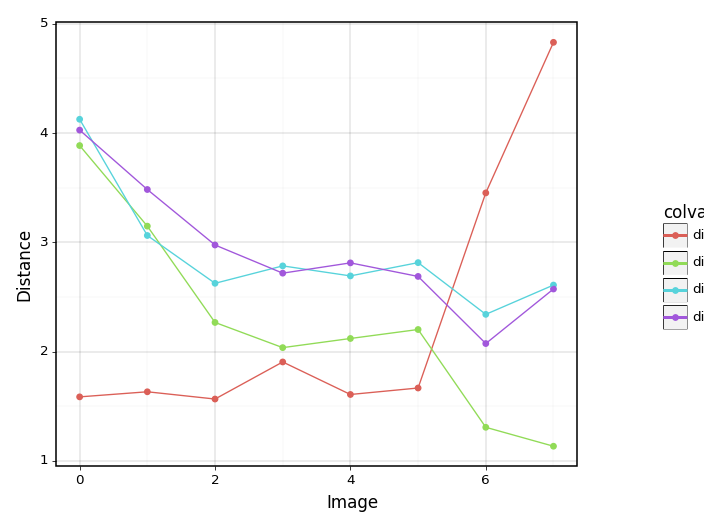

In [137]:
%matplotlib notebook

# Image VS ColvarS, iterated over "time" (string optimization step)

pd.set_option('mode.chained_assignment',None)

playString  = widgets.Play(
    interval=1500,
    value=1,
    min=0,
    max=numIterations-1,
    step=1,
    description="Iterate over the string optimization",
)

playStringSlider = widgets.IntSlider(value=1, min=0, max=numIterations-1)
widgets.jslink((playString,'value'),(playStringSlider,'value'))

stringCtl = widgets.HBox([widgets.Label(value="Iteration:"), playString, playStringSlider])

fig = None
axs = None

def plotString(*args):
    
    global fig, axs
    
    newValue = float(args[0]['new'])
    #print(newValue)
    
    p = p9.ggplot(cvStringMelt.loc[cvStringMelt['Iter'] == newValue,:], \
        p9.aes(x="Image", y='Distance', color="colvar")) + \
        p9.geom_point() + p9.geom_path() + p9.theme_linedraw()
            
    if fig is None:
        fig, plot = p.draw(return_ggplot=True)
        axs = plot.axs
    else:
        for artist in plt.gca().lines +\
                        plt.gca().collections +\
                        plt.gca().artists + plt.gca().patches + plt.gca().texts:
            artist.remove()
        p._draw_using_figure(fig, axs)
    
playStringSlider.observe(plotString, 'value')

display(stringCtl)

playStringSlider.value = 0
plt.tight_layout()

HBox(children=(Label(value='Iteration:'), Play(value=1, description='Iterate over the string optimization', interval=1500, max=3), IntSlider(value=1, max=3)))

HBox(children=(Label(value='X-Diff:'), Dropdown(description='X-Final', index=3, options={'OMP OB <-> Asp59 OD1': 'dist3', 'OMP C6 <-> OMP C7': 'dist0', 'OMP OA <-> Asp59 OD2': 'dist2', 'OMP C6 <-> Lys61 HZ1': 'dist1'}, value='dist1'), Dropdown(description='X-Initial', index=1, options={'OMP OB <-> Asp59 OD1': 'dist3', 'OMP C6 <-> OMP C7': 'dist0', 'OMP OA <-> Asp59 OD2': 'dist2', 'None': None, 'OMP C6 <-> Lys61 HZ1': 'dist1'}, value='dist0')))

HBox(children=(Label(value='Y-Diff:'), Dropdown(description='Y-Final', options={'OMP OB <-> Asp59 OD1': 'dist3', 'OMP C6 <-> OMP C7': 'dist0', 'OMP OA <-> Asp59 OD2': 'dist2', 'OMP C6 <-> Lys61 HZ1': 'dist1'}, value='dist3'), Dropdown(description='Y-Initial', index=2, options={'OMP OB <-> Asp59 OD1': 'dist3', 'OMP C6 <-> OMP C7': 'dist0', 'OMP OA <-> Asp59 OD2': 'dist2', 'None': None, 'OMP C6 <-> Lys61 HZ1': 'dist1'}, value='dist2')))

<IPython.core.display.Javascript object>


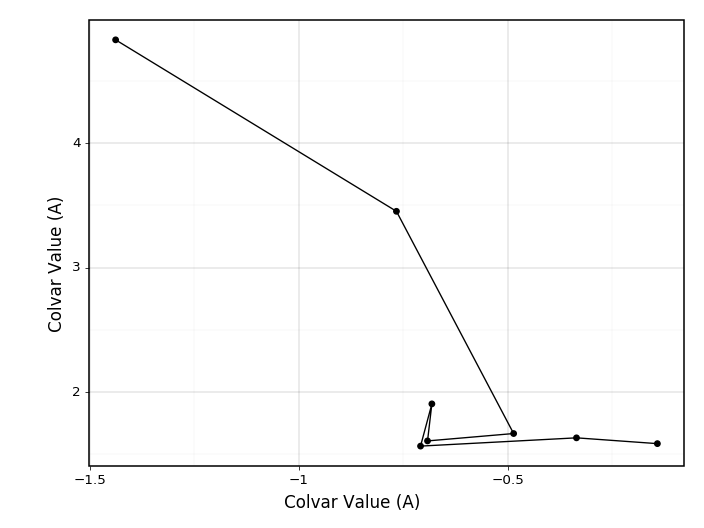

In [95]:
# Colvar X VS Colvar Y

%matplotlib notebook

# Image VS ColvarS, iterated over "time" (string optimization step)

pd.set_option('mode.chained_assignment',None)

playString  = widgets.Play(
    interval=1500,
    value=1,
    min=0,
    max=numIterations-1,
    step=1,
    description="Iterate over the string optimization",
)

playStringSlider = widgets.IntSlider(value=1, min=0, max=numIterations-1)
widgets.jslink((playString,'value'),(playStringSlider,'value'))

stringCtl = widgets.HBox([widgets.Label(value="Iteration:"),playString, playStringSlider])

# We create an inverse dictionary to populate the drop-down boxes
cvNameKeyDict = { val:key for key,val in keyNameDic.items() }
# And add the option of not chosing 
cvNameKeyDictIni = dict(cvNameKeyDict)
cvNameKeyDictIni.update({'None':None})

selXi = widgets.Dropdown(
    options=cvNameKeyDictIni,
    value='dist0',
    description='X-Initial',
)

selXf = widgets.Dropdown(
    options=cvNameKeyDict,
    value='dist1',
    description='X-Final',
)

dropBoxesX = widgets.HBox([widgets.Label(value="X-Diff:",style={'value_width': 'initial'}),
                          selXf,selXi])

selYi = widgets.Dropdown(
    options=cvNameKeyDictIni,
    value='dist2',
    description='Y-Initial',
)

selYf = widgets.Dropdown(
    options=cvNameKeyDict,
    value='dist3',
    description='Y-Final',
)

dropBoxesY = widgets.HBox([widgets.Label(value="Y-Diff:",style={'value_width': 'initial'}),
                          selYf,selYi])

fig = None
axs = None

def plotString(*args):
    
    global fig, axs
    
    #newValue = float(args[0]['new'])
    #print(newValue)
    newValue = float(playStringSlider.value)
    
    tmpDF = cvString.loc[cvString['Iter'] == newValue,:]
    
    # Verifies we have a selection for difference between colvars. If not, only one colvar value is shown.
    if selXi.value:
        tmpDF['xvals'] = tmpDF[selXf.value] - tmpDF[selXi.value]
    else:
        tmpDF['xvals'] = tmpDF[selXf.value]
    
    if selYi.value:
        tmpDF['yvals'] = tmpDF[selYf.value] - tmpDF[selYi.value]
    else:
        tmpDF['yvals'] = tmpDF[selYf.value]
    
    p = p9.ggplot(tmpDF, p9.aes(x="xvals", y="yvals")) + \
        p9.geom_point() + p9.geom_path() + p9.theme_linedraw() +\
        p9.labs(x="Colvar Value (A)", y="Colvar Value (A)")
            
    if fig is None:
        fig, plot = p.draw(return_ggplot=True)
        axs = plot.axs
    else:
        for artist in plt.gca().lines +\
                        plt.gca().collections +\
                        plt.gca().artists + plt.gca().patches + plt.gca().texts:
            artist.remove()
        p._draw_using_figure(fig, axs)
    
playStringSlider.observe(plotString, 'value')

selXf.observe(plotString, "value")
selXi.observe(plotString, "value")
selYf.observe(plotString, "value")
selYi.observe(plotString, "value")

display(stringCtl)
display(dropBoxesX)
display(dropBoxesY)

playStringSlider.value = 0
plt.tight_layout()

### The files for eABF have already been prepared in a previous step. Now, we just run prepare output directories and PDB files from the results of the String Optimization. These PDB files will define the string path over which multiple ABF walkers will "walk".



In [ ]:
if outputPath[-1] == "/":
    tmpOutputPath = outputPath[0:len(outputPath)-1]
    
for i in range(numImgs*eABFWalkersPerImg):
    os.makedirs(tmpOutputPath + "_eABF/" + str(i),exist_ok=True)

os.makedirs(basePath + "/string", exist_ok=True)

In [ ]:
#if parallelExec:
#    multiplier = stringNumWalkers
#elif sequentialExec:
#    multiplier = 1
#
## We look for the coordinate output file from the last string iteration.
#r = re.compile('(iter(\d+))')
#
#for image in range(numImgs):
#    dirIndx = image*multiplier
#    
#    print(dirIndx)
#    
#    fileList = glob.glob('./String_eABF/output/' + str(dirIndx) + "/*image*.coor" )
#    filename = sorted(fileList, key=lambda x: int(r.search(x).group(2)) )[-1]
#    
#    print(filename)
    

In [ ]:
%%bash
cd String_eABF/

../toolkit/collect-configuration 17 decarb

cd string

../../toolkit/catdcd_coor_to_pdb.sh 17 ../decarboxylase.0.psf

cd ../../

### Run eABF simulation

In [ ]:
%%bash

cd String_eABF/

# mpirun -n 17 /Projects/melomcr/NAMD_Gerrit/namd/Linux-x86_64-g++.mpi/namd2 +replicas 17 eABF.tcl +stdout output_aABF/%1d/job00.%1d.log

In [ ]:

# Process results and plot final free energy curve.